# Battle of the neighborhoods - At the German river Rhine

Import needed libraries

In [24]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#%pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import hierarchical clustering
import pylab
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import euclidean_distances

#%pip install folium
import folium # map rendering library

Foursquare credentials

In [2]:
CLIENT_ID = 'LR42PPMSIQLLUL4CQWG2FGYTRRHRTTKAWJPNCEEWOTXCX1Z3' # your Foursquare ID
CLIENT_SECRET = '2NJLDIH30EGQJK0WHDO3SCLEE5X154RZO4ZUDFUHOYEGYQTY' # your Foursquare Secret
#GFPFE4ISXCEUKKHQUGH1STTYHCUXRUPM0BXRX5SHU4CNVVOQ#_=_
ACCESS_TOKEN = 'GJ4U41E4E3D31ISDCO3XAUMO43MPUDOQP15YLMD20CBJZKE2' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

Where is the famous Altstadt of Düsseldorf, its heart?

In [5]:
Ddorf = 'Düsseldorf Altstadt, Germany'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(Ddorf)
D_lat = location.latitude
D_long = location.longitude

# create map of Düseldorf using latitude and longitude values
D_map = folium.Map(location=[D_lat, D_long], zoom_start=11)
folium.Marker(location=[D_lat, D_long], popup='Altstadt').add_to(D_map)
folium.CircleMarker(
    [D_lat, D_long],
    radius=50,
    #popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.3,
    parse_html=False).add_to(D_map) 
D_map

In Düsseldorf we will focus on approximately the above highlighted area.

Where ist the famous Cathedral at the center of Cologne?

In [6]:
Cologne = 'Kölner Dom, Germany'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(Cologne)
C_lat = location.latitude
C_long = location.longitude

# create map of Cologne using latitude and longitude values
C_map = folium.Map(location=[C_lat, C_long], zoom_start=11)
folium.Marker(location=[C_lat, C_long], popup='Dom').add_to(C_map)
folium.CircleMarker(
    [C_lat, C_long],
    radius=50,
    #popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.3,
    parse_html=False).add_to(C_map) 
C_map

In Cologne we will focus on approximately the above highlighted area.

To find the needed Foursquare category search in Cologne for "Brauhaus", the German word for "pub brewery"

In [7]:
search_query = 'Brauhaus'
radius = 5000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, C_lat, C_long, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

# send get request
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df = json_normalize(venues)

<ipython-input-7-d3eda0ac555a>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(venues)


In [8]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Brauhaus Sion,Rhenisch Restaurant,Unter Taschenmacher 5-7,50.939407,6.959445,"[{'label': 'display', 'lat': 50.93940732742724...",230,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Unter Taschenmacher 5-7, 50667 Köln]",NaN,NaN,4b05886bf964a5208ac422e3
1,Peters Brauhaus,Brewery,Mühlengasse 1,50.939096,6.960592,"[{'label': 'display', 'lat': 50.93909562523831...",300,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Mühlengasse 1, 50667 Köln]",NaN,NaN,4b05886bf964a520afc422e3
2,Brauhaus zur Malzmühle,Brewery,Heumarkt 6,50.934673,6.960515,"[{'label': 'display', 'lat': 50.93467331189498...",756,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Heumarkt 6, 50667 Köln]",NaN,NaN,4bad3899f964a520d53a3be3
3,Brauhaus Stüsser,Brewery,Neusser Str. 47,50.952986,6.957156,"[{'label': 'display', 'lat': 50.95298615341455...",1302,50670,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Neusser Str. 47, 50670 Köln]",NaN,NaN,4b5362f2f964a520309a27e3
4,Antik Brauhaus,German Restaurant,Deutzer Freiheit 85-87,50.936863,6.974378,"[{'label': 'display', 'lat': 50.9368631014659,...",1241,50679,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Deutzer Freiheit 85-87, 50679 Köln]",NaN,NaN,4bd1726e77b29c7440968c82


Analyze categories

In [9]:
dataframe_filtered['categories'].value_counts()

Brewery                17
German Restaurant       5
Gastropub               3
Rhenisch Restaurant     3
Candy Store             1
Shrine                  1
Name: categories, dtype: int64

Mostly Brewery, but also German Restaurant, Rheinisch Restaurant and Gastropub.

Search in Düsseldorf for "Brauhaus", the German word for "pub brewery"

In [10]:
search_query = 'Brauhaus'
radius = 5000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, D_lat, D_long, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
# send get request
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

<ipython-input-10-a271130b1df7>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(venues)


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Brauhaus Zum goldenen Handwerk,Brewery,Marktstr. 12-14,51.225424,6.772422,"[{'label': 'display', 'lat': 51.22542389002278...",49,40213,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Marktstr. 12-14, 40213 Düsseldorf]",NaN,58010cd238fa51246503fce2
1,Brauhaus am Dreieck,Brewery,Blücherstr. 6,51.240391,6.782448,"[{'label': 'display', 'lat': 51.24039124749527...",1768,40477,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Blücherstr. 6, 40477 Düsseldorf]",NaN,4b4e11aff964a52067e026e3
2,Brauhaus Zum Weißen Bären,Gastropub,NaN,51.226073,6.775419,"[{'label': 'display', 'lat': 51.226073, 'lng':...",223,NaN,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,[Düsseldorf],NaN,5b097769da2e000039e15cca
3,Brauhaus Joh. Albrecht,Brewery,Niederkasseler Str. 104,51.240367,6.751412,"[{'label': 'display', 'lat': 51.24036708537516...",2171,40547,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Niederkasseler Str. 104, 40547 Düsseldorf]",NaN,4b6d861ff964a5202d7a2ce3
4,Schuhmacher's Brauhaus im Domhof,Gastropub,Germaniastr. 42,51.207270,6.764438,"[{'label': 'display', 'lat': 51.20726976292550...",2138,40223,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Germaniastr. 42, 40223 Düsseldorf]",NaN,4f3182cee4b09fde5e1d080f


Analyze categories

In [11]:
dataframe_filtered['categories'].value_counts()

Brewery              7
Gastropub            3
German Restaurant    1
Name: categories, dtype: int64

Mostly Brewery, but also Gastropub and German Restaurant.

-> Most common categories for search term "Brauhaus" are in both cities Brewery, German Restaurant, Rheinisch Restaurant and Gastropub

Can we become more specific and focus on less categories?

I have searched all four category IDs in Foursuqare and went for each of them through the following loop for Düsseldorf:

In [12]:
cat_ID = '4bf58dd8d48988d155941735'
radius = 3000
D_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, D_lat, D_long, ACCESS_TOKEN, VERSION, cat_ID, radius, LIMIT)

# send get request
D_results = requests.get(D_url).json()

# assign relevant part of JSON to venues
D_venues = D_results['response']['venues']

# tranform venues into a dataframe
D_df = json_normalize(D_venues)
D_df.head()

<ipython-input-12-575c0450154b>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  D_df = json_normalize(D_venues)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
0,4bae74aff964a52098b43be3,Schwan,"[{'id': '4bf58dd8d48988d10d941735', 'name': 'G...",v-1613921638,False,Mühlenstr. 2,Burgplatz,51.227288,6.772014,"[{'label': 'display', 'lat': 51.22728783869900...",160,40213,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Mühlenstr. 2 (Burgplatz), 40213 Düsseldorf]",NaN,NaN
1,4de17601c65b7a3e210355f4,Hopper,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921638,False,Lanker Str. 8,NaN,51.232361,6.746964,"[{'label': 'display', 'lat': 51.23236122141026...",1904,40545,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Lanker Str. 8, 40545 Düsseldorf]",NaN,NaN
2,5b097769da2e000039e15cca,Brauhaus Zum Weißen Bären,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921638,False,NaN,NaN,51.226073,6.775419,"[{'label': 'display', 'lat': 51.226073, 'lng':...",223,NaN,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,[Düsseldorf],NaN,NaN
3,5f32dba181642e3ba67a6e06,Kitchen,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921638,False,"Lennestraße, 1",Tußmannstrase,51.239590,6.793065,"[{'label': 'display', 'lat': 51.23959, 'lng': ...",2109,40477,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Lennestraße, 1 (Tußmannstrase), 40477 Düsseld...",Pempelfort,NaN
4,4f3182cee4b09fde5e1d080f,Schuhmacher's Brauhaus im Domhof,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921638,False,Germaniastr. 42,NaN,51.207270,6.764438,"[{'label': 'display', 'lat': 51.20726976292550...",2138,40223,DE,Düsseldorf,Nordrhein-Westfalen,Deutschland,"[Germaniastr. 42, 40223 Düsseldorf]",NaN,NaN


In [13]:
D_df.shape

(27, 19)

We have 43 Gastropubs 3 km around Altstadt in Düsseldorf.

In [14]:
D_df['name'].str.count('Brau').sum()

3

Only 4 Gastropubs have "Brau" (for "Brauhaus" or "Brauerei") in its name.

Findings after checking all four cat_IDs:
- 9 out of 34 Breweries contain "Brau" in their names: about **1/4**
- Only 2 out of 6 Rheinisch Restaurants contain "Brau" in their names: **1/3**
- Only 5 out of 48 German Restaurant contain "Brau" in their names: **1/10**
- Only 4 out of 43 Gastropubs contain "Brau" in their names: **1/10**

-> Downtown Düsseldorf are 20 venues with "Brau" in their names in common beer pub categories

Let us check all four category IDs in Foursuqare for Cologne with the same loop, in the following only shown once:

In [16]:
cat_ID = '4bf58dd8d48988d155941735'
radius = 3000
C_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, C_lat, C_long, ACCESS_TOKEN, VERSION, cat_ID, radius, LIMIT)

# send get request
C_results = requests.get(C_url).json()

# assign relevant part of JSON to venues
C_venues = C_results['response']['venues']

# tranform venues into a dataframe
C_df = json_normalize(C_venues)
C_df.head()

<ipython-input-16-faed8c5af135>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  C_df = json_normalize(C_venues)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.crossStreet
0,516f0eede4b026993e982ff4,Kunibert der Fiese,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921704,False,Am Bollwerk 1-5,50.939410,6.962063,"[{'label': 'display', 'lat': 50.93941006471775...",346,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Am Bollwerk 1-5, 50667 Köln]",NaN,NaN
1,564074dacd10564a8404d104,Brauhaus zum Prinzen,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921704,False,Alter Markt 20-22,50.938047,6.960304,"[{'label': 'display', 'lat': 50.938047, 'lng':...",393,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Alter Markt 20-22, 50667 Köln]",563109369,NaN
2,4b38fcbef964a520ab5325e3,Hof 18 Restaurant,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921704,False,Am Hof 12-18,50.940089,6.957522,"[{'label': 'display', 'lat': 50.94008940702583...",141,50667,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Am Hof 12-18, 50667 Köln]",NaN,NaN
3,52beffe6498e511fc4019373,tiroler alm,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921704,False,NaN,50.947857,6.943445,"[{'label': 'display', 'lat': 50.947857, 'lng':...",1262,NaN,DE,Köln,Nordrhein-Westfalen,Deutschland,[Köln],NaN,NaN
4,5bc8b52c5c68380039082771,C.C. Kowalski,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",v-1613921704,False,Brüsseler Straße 70,50.938373,6.934801,"[{'label': 'display', 'lat': 50.938373, 'lng':...",1669,50674,DE,Köln,Nordrhein-Westfalen,Deutschland,"[Brüsseler Straße 70, 50674 Köln]",NaN,NaN


In [17]:
C_df.shape

(30, 18)

We have 49 Gastropubs 3 km around the Cathedral of Cologne.

In [18]:
D_df['name'].str.count('Brau').sum()

3

Only for of them have "Brau" (for "Brauhaus" or "Brauerei") in its name.

Findings after checking all four cat_IDs:
- 4 out of 17 Rheinisch Restaurants contain "Brau" in their names: **1/4**
- Only 4 out of 38 Breweries contain "Brau" in their names: about **1/10**
- Only 4 out of 50 German Restaurant contain "Brau" in their names: less than **1/10**
- Only 4 out of 49 Gastropubs contain "Brau" in their names: **1/10**

-> Downtown Cologne are 16 venues with "Brau" in their names in common beer pub categories

Of course we have in Germany many "German Restaurants" and very few of them have its own brewery. A "Gastropub" seems to be more like a normal pub with beer from a different place and some food.

We will focus on the categories "Rheinisch Restaurant" and "Brewery" for our "pub breweries". (And I see the most famous ones included in these categories.

Let us visualize the identified "Rheinisch Restaurants" and "Breweries" in downtown Düsseldorf and Cologne.

In [19]:
cat_ID_RR = '56aa371ce4b08b9a8d57357b'
cat_ID_B = '50327c8591d4c4b30a586d5d'

In [20]:
radius = 3000
D_url_RR = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, D_lat, D_long, ACCESS_TOKEN, VERSION, cat_ID_RR, radius, LIMIT)
D_url_B = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, D_lat, D_long, ACCESS_TOKEN, VERSION, cat_ID_B, radius, LIMIT)
# send get request
D_results_RR = requests.get(D_url_RR).json()
D_results_B = requests.get(D_url_B).json()
# assign relevant part of JSON to venues
D_venues_RR = D_results_RR['response']['venues']
D_venues_B = D_results_B['response']['venues']
# tranform venues into a dataframe
D_df_RR = json_normalize(D_venues_RR)
D_df_B = json_normalize(D_venues_B)
D_df = pd.concat([D_df_RR, D_df_B], ignore_index=True)

# create map of Düsseldorf using latitude and longitude values
D_map = folium.Map(location=[D_lat, D_long], zoom_start=13)

# add markers to map
for lat, lng, label in zip(D_df['location.lat'], D_df['location.lng'], D_df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(D_map)  
    
D_map

<ipython-input-20-ed7009a540e6>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  D_df_RR = json_normalize(D_venues_RR)
<ipython-input-20-ed7009a540e6>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  D_df_B = json_normalize(D_venues_B)


# -> Downtown Düsseldorf are 40 "Rheinisch Restaurants" and Breweries

We see a concentration in the "Altstadt" with less than half of the inspected group surrounding it.

In [21]:
radius = 3000
C_url_RR = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, C_lat, C_long, ACCESS_TOKEN, VERSION, cat_ID_RR, radius, LIMIT)
C_url_B = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, C_lat, C_long, ACCESS_TOKEN, VERSION, cat_ID_B, radius, LIMIT)
# send get request
C_results_RR = requests.get(C_url_RR).json()
C_results_B = requests.get(C_url_B).json()
# assign relevant part of JSON to venues
C_venues_RR = C_results_RR['response']['venues']
C_venues_B = C_results_B['response']['venues']
# tranform venues into a dataframe
C_df_RR = json_normalize(C_venues_RR)
C_df_B = json_normalize(C_venues_B)
C_df = pd.concat([C_df_RR, C_df_B], ignore_index=True)

# create map of Cologne using latitude and longitude values
C_map = folium.Map(location=[C_lat, C_long], zoom_start=13)

# add markers to map
for lat, lng, label in zip(C_df['location.lat'], C_df['location.lng'], C_df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(C_map)  
    
C_map

<ipython-input-21-00087e85d74f>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  C_df_RR = json_normalize(C_venues_RR)
<ipython-input-21-00087e85d74f>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  C_df_B = json_normalize(C_venues_B)


# -> Downtown Cologne are 55 "Rheinisch Restaurants" and Breweries

We see a concentration at the Cathedral with many more surrounding it.

Let us look for clusters using hierarchical clustering with a dendogram to visualize clusters, first for Düsseldorf.

In [22]:
featureset = D_df[['location.lat', 'location.lng']]

D = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
D_feature_mtx = min_max_scaler.fit_transform(D)

D_dist_matrix = euclidean_distances(D_feature_mtx,D_feature_mtx)

D_using_dist_matrix = hierarchy.linkage(D_dist_matrix, 'weighted')

<ipython-input-22-469107fd114f>:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  D_using_dist_matrix = hierarchy.linkage(D_dist_matrix, 'weighted')


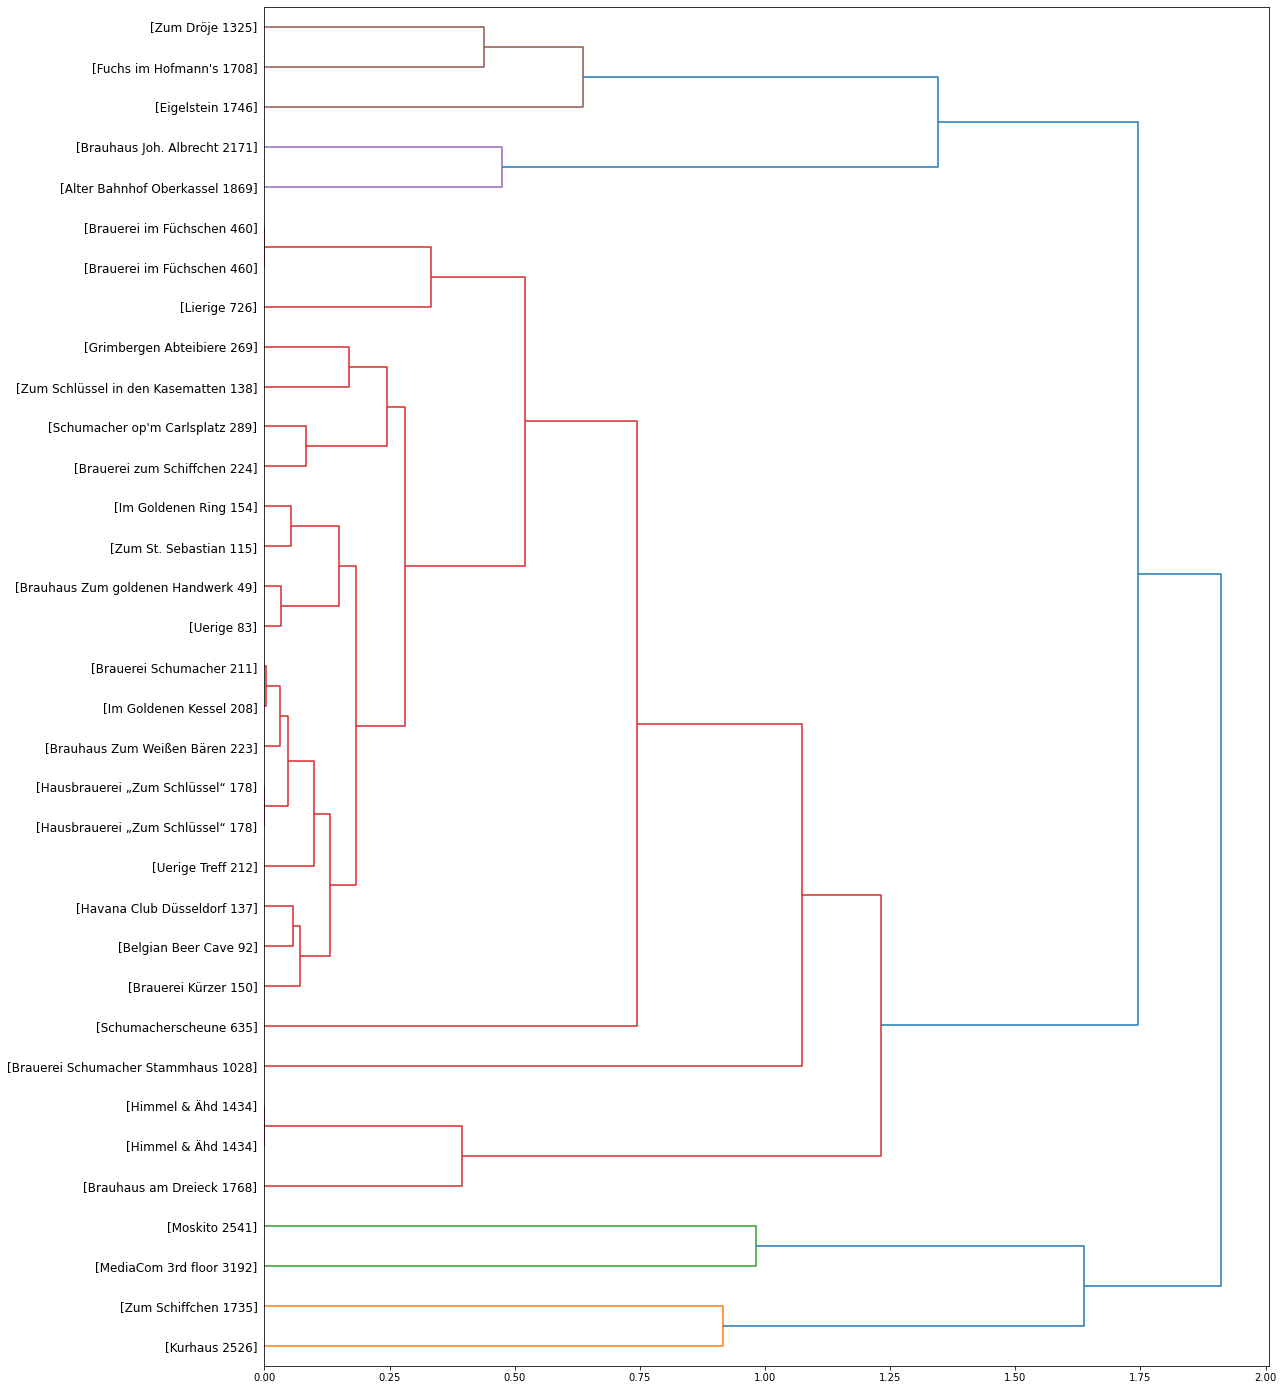

In [25]:
fig = pylab.figure(figsize=(18,25))
def llf(id):
    #return 'D_df[name][id]'
    return '[%s %s]' % (D_df['name'][id], D_df['location.distance'][id])
    
dendro = hierarchy.dendrogram(D_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

# -> In Düsseldorf we see a cluster of 22 venues up to 1096 m around the "Altstadt"

Let us look in Cologne, too:

<ipython-input-26-4f41c8846fa7>:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  C_using_dist_matrix = hierarchy.linkage(C_dist_matrix, 'weighted')


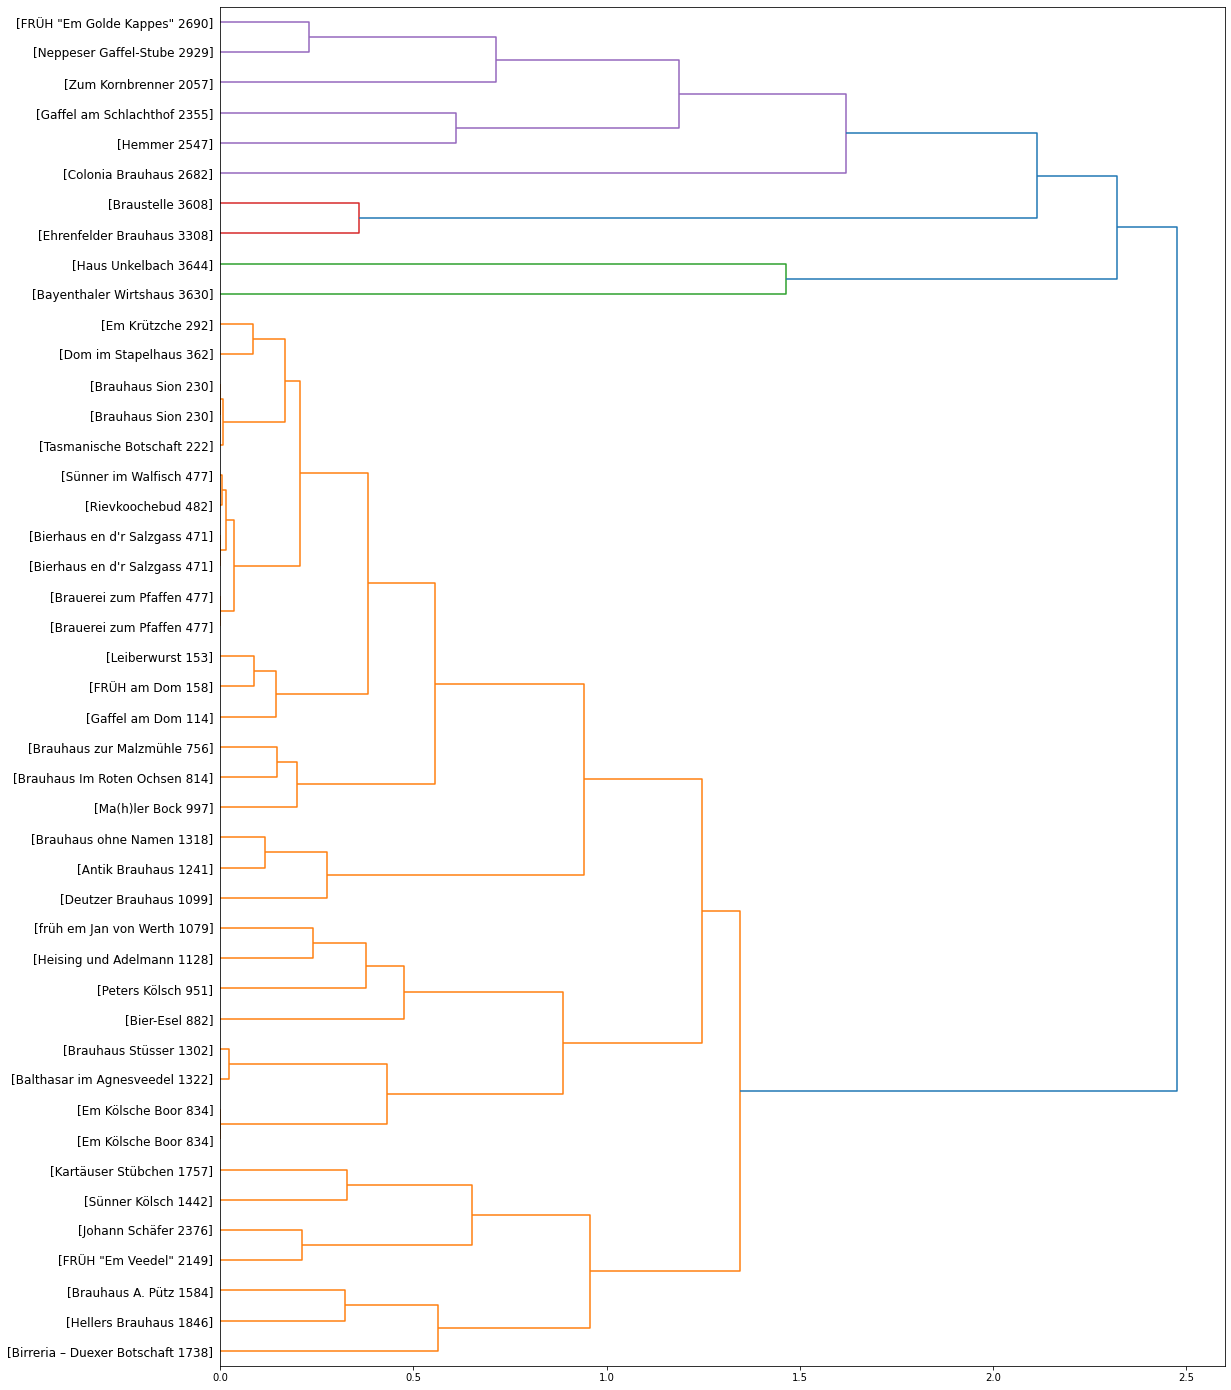

In [26]:
featureset = C_df[['location.lat', 'location.lng']]

C = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
C_feature_mtx = min_max_scaler.fit_transform(C)

C_dist_matrix = euclidean_distances(C_feature_mtx,C_feature_mtx) 

C_using_dist_matrix = hierarchy.linkage(C_dist_matrix, 'weighted')

fig = pylab.figure(figsize=(18,25))
def llf(id):
    return '[%s %s]' % (C_df['name'][id], C_df['location.distance'][id])
    
dendro = hierarchy.dendrogram(C_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

# -> In Cologne we see a cluster of 16 venues up to 997 m around the Cathedrale

There are other clusters, but smaller in size and/or arger in its area.